<a href="https://colab.research.google.com/github/skardec/deeply_kardec/blob/main/optimization_industryKKT2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [25]:
# =======================
# KKT cylinder optimization — Colab-ready script
# =======================


In [38]:
"""

Produzir um cilindro de volume fixo \(V=900\ \mathrm{cm}^3\). O custo do material da \emph{lateral} do
cilindro (por área) é o custo de referência: \(c_\ell\). O material da \emph{base} custa \(3c_\ell\) por área e
o material do \emph{topo} custa \(2c_\ell\) por área. Dá-se \(c_\ell = \SI{140}{\$ / m^2}\). A altura do cilindro
não pode exceder \(H_{\max}=\SI{20}{cm}\). Objetivo: minimizar o custo de produção por unidade.

"""

<>:3: SyntaxWarning: invalid escape sequence '\('
<>:3: SyntaxWarning: invalid escape sequence '\('
/tmp/ipython-input-2730282903.py:3: SyntaxWarning: invalid escape sequence '\('
  Produzir um cilindro de volume fixo \(V=900\ \mathrm{cm}^3\). O custo do material da \emph{lateral} do


'\n\nProduzir um cilindro de volume fixo \\(V=900\\ \\mathrm{cm}^3\\). O custo do material da \\emph{lateral} do \ncilindro (por área) é o custo de referência: \\(c_\\ell\\). O material da \\emph{base} custa \\(3c_\\ell\\) por área e\no material do \\emph{topo} custa \\(2c_\\ell\\) por área. Dá-se \\(c_\\ell = \\SI{140}{\\$ / m^2}\\). A altura do cilindro \nnão pode exceder \\(H_{\\max}=\\SI{20}{cm}\\). Objetivo: minimizar o custo de produção por unidade.\n\n'

In [26]:
# ----- imports -----
import numpy as np
import sympy as sp
from math import isclose
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # 3D
from numpy.linalg import eigvals, norm
from sympy import pi
import os


In [27]:



# For inline plotting in Colab, matplotlib works by default; you can also use:
# %matplotlib inline

# ----------------------------- Problem parameters --------------------------------
V_val = 900.0           # required volume in cm^3
H_max = 19.0 #or 20           # maximum allowed height in cm (constraint)
c_l_m2 = 140.0          # lateral material cost in $ / m^2 (given)
# convert material costs to $ / cm^2 (1 m^2 = 10^4 cm^2)
c_l = c_l_m2 / 1e4      # lateral cost $/cm^2
c_base = 3.0 * c_l      # base material cost per area is 3x lateral
c_top  = 2.0 * c_l      # top material cost per area is 2x lateral

print("Problem parameters:")
print(f"  Volume V = {V_val} cm^3")
print(f"  Height limit H_max = {H_max} cm")
print(f"  Lateral cost c_l = ${c_l:.6f} per cm^2")
print(f"  Base cost c_base = ${c_base:.6f} per cm^2")
print(f"  Top cost c_top = ${c_top:.6f} per cm^2\n")

Problem parameters:
  Volume V = 900.0 cm^3
  Height limit H_max = 19.0 cm
  Lateral cost c_l = $0.014000 per cm^2
  Base cost c_base = $0.042000 per cm^2
  Top cost c_top = $0.028000 per cm^2



In [28]:
# ----------------------------- Symbolic setup ------------------------------------
# Symbols: r (radius), h (height), lam (lambda for equality), mu (multiplier for inequality)
r, h, lam, mu = sp.symbols('r h lam mu', real=True)

# Cost function C(r,h) in symbolic form (units $)
C_sym = c_l*(2*sp.pi*r*h) + c_base*(sp.pi*r**2) + c_top*(sp.pi*r**2)

# Equality constraint: volume
g1 = sp.pi*r**2*h - V_val  # = 0

# Inequality constraint: h - H_max <= 0
g2 = h - H_max

# Lagrangian including both multipliers (mu for inequality)
L_sym = C_sym + lam*g1 + mu*g2

# Stationarity conditions (partial derivatives = 0)
dL_dr = sp.simplify(sp.diff(L_sym, r))
dL_dh = sp.simplify(sp.diff(L_sym, h))

print("Symbolic partial derivatives computed.\n")


Symbolic partial derivatives computed.



In [29]:



# ----------------------------- Analytical solution (derived) ---------------------
r_analytic = (V_val / (5.0 * np.pi))**(1.0/3.0)
h_analytic = 5.0 * r_analytic

def cost_numeric(rn, hn):
    """Compute numeric cost for given radius (cm) and height (cm)."""
    return c_l*(2*np.pi*rn*hn) + c_base*(np.pi*rn**2) + c_top*(np.pi*rn**2)

cost_analytic = cost_numeric(r_analytic, h_analytic)

print("Analytical solution from calculus (derived):")
print(f"  r_analytic = {r_analytic:.6f} cm")
print(f"  h_analytic = {h_analytic:.6f} cm")
print(f"  C_analytic = ${cost_analytic:.6f} per unit\n")

Analytical solution from calculus (derived):
  r_analytic = 3.855146 cm
  h_analytic = 19.275732 cm
  C_analytic = $9.805075 per unit



In [30]:

# ----------------------------- Numerical KKT solve (mu = 0) ---------------------
# We solve the system: dL_dr = 0, dL_dh = 0, g1 = 0 with mu = 0
dL_dr_mu0 = dL_dr.subs(mu, 0)
dL_dh_mu0 = dL_dh.subs(mu, 0)

eq1 = sp.Eq(dL_dr_mu0, 0)
eq2 = sp.Eq(dL_dh_mu0, 0)
eq3 = sp.Eq(g1, 0)

In [31]:


# Use sympy.nsolve with a reasonable initial guess
initial_guess = (3.5, 19.0, -0.01)  # (r, h, lam)
try:
    sol_numeric = sp.nsolve([eq1, eq2, eq3], [r, h, lam], initial_guess, tol=1e-14, maxsteps=200)
    r_star = float(sol_numeric[0])
    h_star = float(sol_numeric[1])
    lam_star = float(sol_numeric[2])
    cost_star = cost_numeric(r_star, h_star)
    print("Numerical solution of KKT stationarity (mu=0):")
    print(f"  r* = {r_star:.6f} cm")
    print(f"  h* = {h_star:.6f} cm")
    print(f"  lambda* = {lam_star:.6e}")
    print(f"  C* = ${cost_star:.6f} per unit\n")
except Exception as e:
    print("Numerical solve of KKT (mu=0) failed:", e)
    r_star = None
    h_star = None
    lam_star = None
    cost_star = None

Numerical solution of KKT stationarity (mu=0):
  r* = 3.855146 cm
  h* = 19.275732 cm
  lambda* = -7.263019e-03
  C* = $9.805075 per unit



In [32]:

# ----------------------------- Active height case (mu > 0) ----------------------
# If height constraint is active, h = H_max and r determined by volume
r_active = np.sqrt(V_val / (np.pi * H_max))
h_active = H_max
cost_active = cost_numeric(r_active, h_active)

print("Case with active height constraint (h = H_max):")
print(f"  r (if h=H_max) = {r_active:.6f} cm")
print(f"  h = {h_active:.6f} cm")
print(f"  C (h=H_max) = ${cost_active:.6f} per unit\n")

Case with active height constraint (h = H_max):
  r (if h=H_max) = 3.883019 cm
  h = 19.000000 cm
  C (h=H_max) = $9.805585 per unit



In [33]:




# ----------------------------- Choose best feasible solution --------------------
# If KKT solution exists and respects h <= H_max, compare costs; otherwise choose active
if r_star is not None:
    if h_star <= H_max + 1e-9:
        if cost_star <= cost_active:
            chosen = ('kkt_inactive', r_star, h_star, cost_star)
        else:
            chosen = ('height_active', r_active, h_active, cost_active)
    else:
        chosen = ('height_active', r_active, h_active, cost_active)
else:
    chosen = ('height_active', r_active, h_active, cost_active)

print("Chosen best feasible solution:")
print(f"  Type: {chosen[0]}, r = {chosen[1]:.6f} cm, h = {chosen[2]:.6f} cm, cost = ${chosen[3]:.6f}\n")

Chosen best feasible solution:
  Type: height_active, r = 3.883019 cm, h = 19.000000 cm, cost = $9.805585



In [34]:


# ----------------------------- Second-order check (Projected Hessian) ----------
H11 = sp.diff(dL_dr, r)
H12 = sp.diff(dL_dr, h)
H21 = sp.diff(dL_dh, r)
H22 = sp.diff(dL_dh, h)
H_mat_sym = sp.Matrix([[H11, H12], [H21, H22]])
H_func = sp.lambdify((r, h, lam, mu), H_mat_sym, 'numpy')

if r_star is not None:
    H_num = np.array(H_func(r_star, h_star, lam_star, 0.0), dtype=float)
    # Gradient of equality constraint g1 at (r,h): grad_g1 = [2*pi*r*h, pi*r^2]
    grad_g1 = np.array([2*np.pi*r_star*h_star, np.pi*r_star**2], dtype=float)
    # Tangent vector in 2D is orthogonal to grad_g1
    t = np.array([-grad_g1[1], grad_g1[0]], dtype=float)
    t_norm = norm(t)
    if t_norm < 1e-12:
        print("Warning: gradient of constraint practically zero; can't form tangent space.")
    else:
        q = t / t_norm  # unit tangent basis (1-vector)
        Q = q.reshape(2,1)
        # Projected Hessian: B = Q^T H Q (scalar here)
        B = Q.T.dot(H_num.dot(Q))
        eigs_full = eigvals(H_num)
        print("Hessian of Lagrangian at KKT solution (2x2):")
        print(H_num)
        print("Eigenvalues of full Hessian:", eigs_full)
        print("Projected Hessian on tangent space (scalar):", float(B[0,0]))
        print("Projected Hessian > 0 ? :", float(B[0,0]) > 0, "\n")
else:
    print("Skipping second-order check (no KKT solution found).\n")

Hessian of Lagrangian at KKT solution (2x2):
[[-0.43982297 -0.08796459]
 [-0.08796459  0.        ]]
Eigenvalues of full Hessian: [-0.4567634   0.01694043]
Projected Hessian on tangent space (scalar): 0.013064048658492212
Projected Hessian > 0 ? : True 



Saved cost plot to: kkt_cylinder_output/cost_vs_radius.png


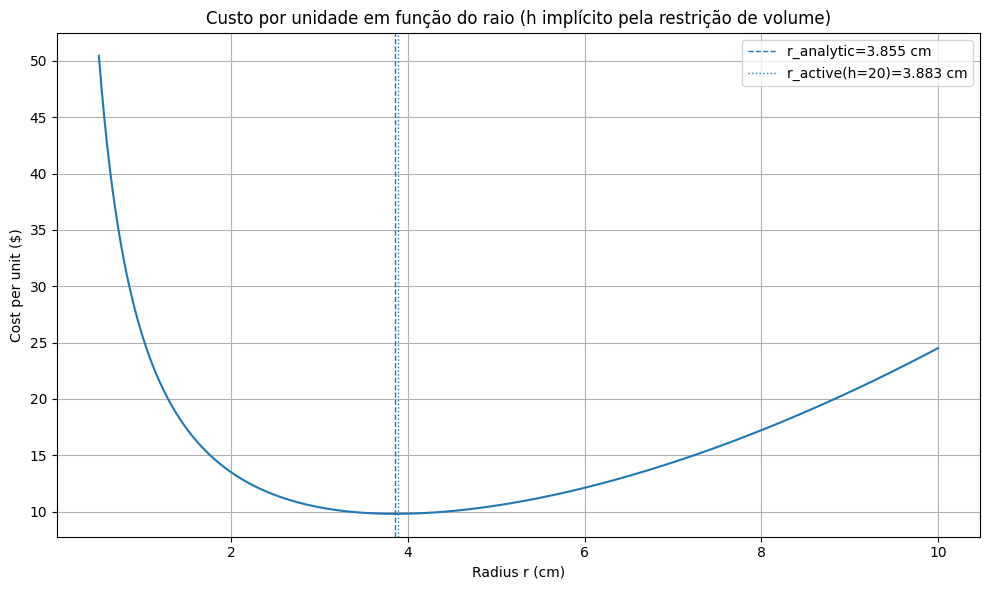

Saved 3D cylinder plot to: kkt_cylinder_output/cylinder_3d.png


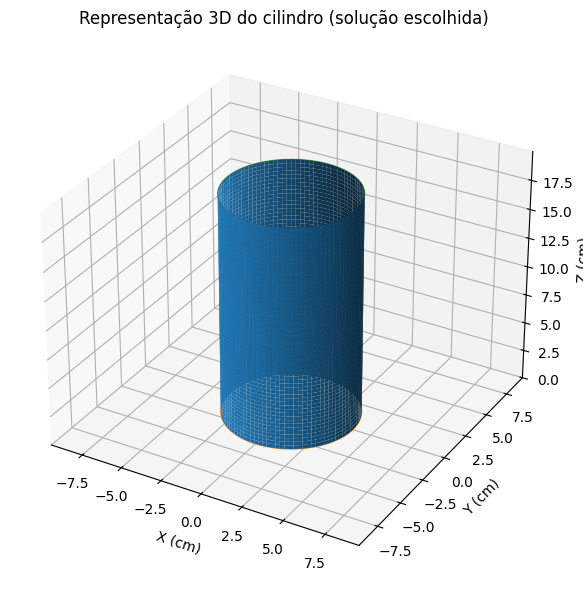

In [35]:


# ----------------------------- Visualizations ----------------------------------
# Create output directory for images
outdir = "kkt_cylinder_output"
os.makedirs(outdir, exist_ok=True)

# 1) Plot cost as a function of radius r (with implied h = V/(pi*r^2))
r_vals = np.linspace(0.5, 10.0, 600)  # avoid r too small to prevent enormous h
h_vals = V_val / (np.pi * r_vals**2)
cost_vals = [cost_numeric(rv, hv) for rv, hv in zip(r_vals, h_vals)]

plt.figure(figsize=(10,6))
plt.plot(r_vals, cost_vals)
plt.axvline(r_analytic, linestyle='--', linewidth=1, label=f"r_analytic={r_analytic:.3f} cm")
plt.axvline(r_active, linestyle=':', linewidth=1, label=f"r_active(h=20)={r_active:.3f} cm")
plt.xlabel('Radius r (cm)')
plt.ylabel('Cost per unit ($)')
plt.title('Custo por unidade em função do raio (h implícito pela restrição de volume)')
plt.legend()
plt.grid(True)
plt.tight_layout()
cost_plot_path = os.path.join(outdir, "cost_vs_radius.png")
plt.savefig(cost_plot_path, dpi=200)
print(f"Saved cost plot to: {cost_plot_path}")
plt.show()

# 2) 3D plot of the optimal cylinder (surface) - uses chosen solution
r_plot = chosen[1]
h_plot = chosen[2]

theta = np.linspace(0, 2*np.pi, 100)
z = np.linspace(0, h_plot, 60)
Theta, Z = np.meshgrid(theta, z)
X = r_plot * np.cos(Theta)
Y = r_plot * np.sin(Theta)
Z = Z

fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(X, Y, Z, rstride=1, cstride=1, linewidth=0, antialiased=True)
# plot top and bottom circle edges
theta_fine = np.linspace(0, 2*np.pi, 300)
xb = r_plot * np.cos(theta_fine)
yb = r_plot * np.sin(theta_fine)
zb = np.zeros_like(theta_fine)
zt = np.ones_like(theta_fine) * h_plot
ax.plot(xb, yb, zb, linewidth=0.8)
ax.plot(xb, yb, zt, linewidth=0.8)
ax.set_xlabel('X (cm)')
ax.set_ylabel('Y (cm)')
ax.set_zlabel('Z (cm)')
ax.set_title('Representação 3D do cilindro (solução escolhida)')
# adjust axes to look balanced
max_range = np.array([X.max()-X.min(), Y.max()-Y.min(), h_plot]).max() / 2.0
mid_x = (X.max()+X.min()) * 0.5
mid_y = (Y.max()+Y.min()) * 0.5
ax.set_xlim(mid_x - max_range, mid_x + max_range)
ax.set_ylim(mid_y - max_range, mid_y + max_range)
ax.set_zlim(0, h_plot*1.05)
plt.tight_layout()
cyl_plot_path = os.path.join(outdir, "cylinder_3d.png")
plt.savefig(cyl_plot_path, dpi=200)
print(f"Saved 3D cylinder plot to: {cyl_plot_path}")
plt.show()




In [36]:
 #----------------------------- Summary output ----------------------------------
print("FINAL SUMMARY:")
print(f"  Analytical: r = {r_analytic:.6f} cm, h = {h_analytic:.6f} cm, cost = ${cost_analytic:.6f}")
if r_star is not None:
    print(f"  KKT numerical: r = {r_star:.6f} cm, h = {h_star:.6f} cm, cost = ${cost_star:.6f}")
print(f"  Height-active: r = {r_active:.6f} cm, h = {h_active:.6f} cm, cost = ${cost_active:.6f}")
print(f"  Chosen best feasible: {chosen[0]}, r = {chosen[1]:.6f}, h = {chosen[2]:.6f}, cost = ${chosen[3]:.6f}")
print("\nNotes:")
print("- The numerical KKT solution (mu=0) should match the analytic solution.")
print("- The projected Hessian on the tangent space (if computed) indicates local minimality if >0.")

print(f"\nFiles saved in the directory '{outdir}':")
for fn in os.listdir(outdir):
    print(" -", fn)



FINAL SUMMARY:
  Analytical: r = 3.855146 cm, h = 19.275732 cm, cost = $9.805075
  KKT numerical: r = 3.855146 cm, h = 19.275732 cm, cost = $9.805075
  Height-active: r = 3.883019 cm, h = 19.000000 cm, cost = $9.805585
  Chosen best feasible: height_active, r = 3.883019, h = 19.000000, cost = $9.805585

Notes:
- The numerical KKT solution (mu=0) should match the analytic solution.
- The projected Hessian on the tangent space (if computed) indicates local minimality if >0.

Files saved in the directory 'kkt_cylinder_output':
 - cost_vs_radius.png
 - cylinder_3d.png
